In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

import sys
sys.path.append('/home/rustam/hyperspecter_segmentation/makitorch')
sys.path.append('/home/rustam/hyperspecter_segmentation/')

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.ndimage import gaussian_filter
import cv2
from hsi_dataset_api import HsiDataset

In [2]:
# https://forums.fast.ai/t/multi-class-semantic-segmentation-metrics-and-accuracy/74665/2 # Check
 
# https://github.com/qubvel/segmentation_models.pytorch/issues/422

# https://github.com/qubvel/segmentation_models.pytorch/blob/master/segmentation_models_pytorch/losses/dice.py

# https://towardsdatascience.com/metrics-to-evaluate-your-semantic-segmentation-model-6bcb99639aa2

In [5]:
pca_explained_variance = np.load('../PcaExplainedVariance_.npy')
pca_mean = np.load('../PcaMean.npy')
pca_components = np.load('../PcaComponents.npy')

In [6]:
def pca_transformation(x):
    x_t = np.reshape(x, (x.shape[0], -1)) # (C, H, W) -> (C, H * W)
    x_t = np.swapaxes(x_t, 0, 1) # (C, H * W) -> (H * W, C)
    x_t = x_t - pca_mean
    x_t = np.dot(x_t, pca_components.T) / np.sqrt(pca_explained_variance)
    return np.reshape(x_t, (x.shape[1], x.shape[2], pca_components.shape[0])).astype(np.float32) # (H, W, N)

In [7]:
test_indices = np.load('../test_indices.npy')
train_indices = np.load('../train_indices.npy')
path = '/raid/rustam/hyperspectral_dataset/new_cropped_hsi_data/'

In [8]:
dataset = HsiDataset(path)

In [9]:
images = []
masks = []

for idx, data_point in enumerate(dataset.data_iterator(opened=True, shuffle=False)):
    if test_indices is not None and idx not in test_indices:
        continue
    images.append(data_point.hsi)
    masks.append(data_point.mask)

In [10]:
test_stats = np.array([0]*17)
for mask in masks:
    print(np.unique(mask), np.bincount(np.unique(mask), minlength=17))
    test_stats += np.bincount(np.unique(mask), minlength=17)
test_stats

[0 1] [1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0 10] [1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
[ 0  7 10] [1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0]
[0 4 5 7] [1 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0]
[0 5] [1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
[0 4 5] [1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0]
[ 0  4  5  7 10] [1 0 0 0 1 1 0 1 0 0 1 0 0 0 0 0 0]
[0 1 4 5] [1 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0]
[0 2] [1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  2 16] [1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
[ 0  5  7 10] [1 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0]
[0 5 7] [1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0]
[ 0 10 16] [1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1]
[ 0  7 10 16] [1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1]
[ 0  7 16] [1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1]
[ 0  9 11 16] [1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1]
[ 0 12] [1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
[0 4] [1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
[0 3] [1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  3 10] [1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0]
[ 0 13] [1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
[0 8] [1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0

array([37,  3,  3,  2,  9,  9,  3, 12,  3,  2,  8,  1,  1,  1,  2,  3, 10])

In [11]:
class2count = dict([(f'{i}', 0) for i in range(17)])
for mask in masks:
    print(np.unique(mask), np.bincount(np.unique(masks[0]), minlength=17))
    for i in range(17):
        if i in mask:
            class2count[str(i)] += 1
class2count

[0 1] [1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0 10] [1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  7 10] [1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 4 5 7] [1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 5] [1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 4 5] [1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  4  5  7 10] [1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 1 4 5] [1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 2] [1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  2 16] [1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  5  7 10] [1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 5 7] [1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0 10 16] [1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  7 10 16] [1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  7 16] [1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  9 11 16] [1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0 12] [1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 4] [1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 3] [1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  3 10] [1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0 13] [1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 8] [1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

{'0': 37,
 '1': 3,
 '2': 3,
 '3': 2,
 '4': 9,
 '5': 9,
 '6': 3,
 '7': 12,
 '8': 3,
 '9': 2,
 '10': 8,
 '11': 1,
 '12': 1,
 '13': 1,
 '14': 2,
 '15': 3,
 '16': 10}

In [12]:
i=2

In [13]:
i +=1

In [14]:
hyperspecter = images[i].copy()
h_pca = pca_transformation(hyperspecter)
mask = masks[i].copy()

In [15]:
hyperspecter.shape, h_pca.shape

((237, 512, 512), (512, 512, 17))

<AxesSubplot:>

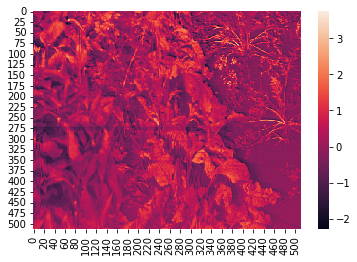

In [16]:
sns.heatmap(h_pca[..., 2])

<AxesSubplot:>

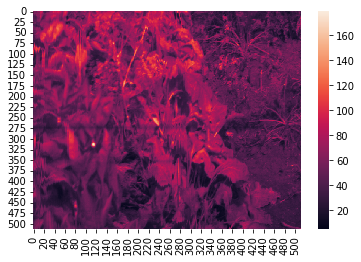

In [17]:
sns.heatmap(hyperspecter[120])

In [18]:
normed_h = (hyperspecter - hyperspecter.min()) / (hyperspecter.max() - hyperspecter.min())

<AxesSubplot:>

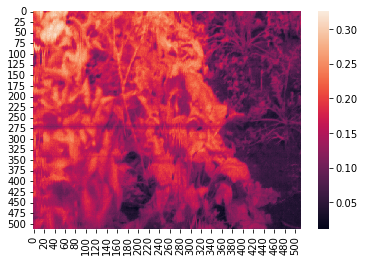

In [19]:
sns.heatmap(normed_h[200])

<AxesSubplot:>

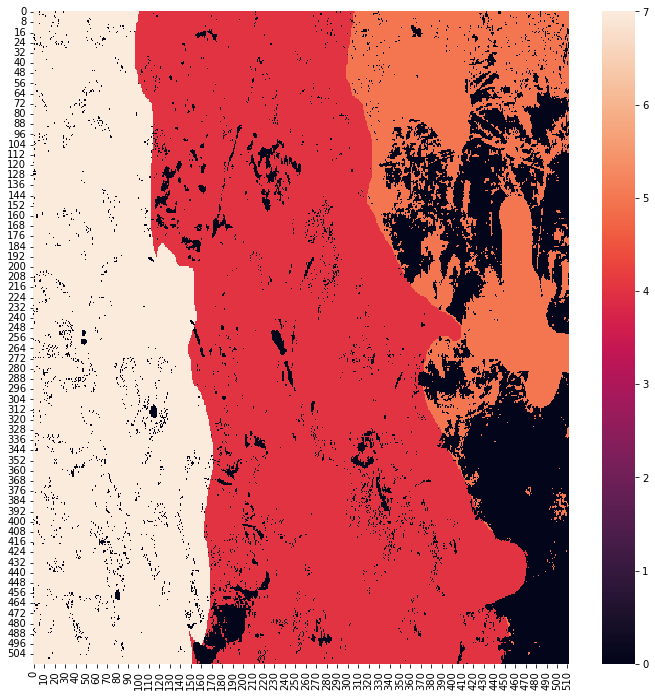

In [20]:
plt.figure(figsize=(12,12))
sns.heatmap(mask[..., 0])

In [21]:
mask_s = mask[..., 0].copy()

In [22]:
from sklearn.metrics import jaccard_score

In [23]:
def matrix2onehot(matrix, num_classes=17):
    matrix = matrix.copy().reshape(-1)
    one_hoted = np.zeros((matrix.size, num_classes))
    one_hoted[np.arange(matrix.size),matrix] = 1
    return one_hoted

In [15]:
mask_s.shape

(512, 512)

In [20]:
one_hoted = matrix2onehot(mask_s)
res = jaccard_score(one_hoted, one_hoted, average=None, zero_division=1)
res, res.shape, res.mean()

(array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 (16,),
 1.0)

In [21]:
np.unique(mask_s)

array([0, 2], dtype=uint8)

https://forums.fast.ai/t/multi-class-semantic-segmentation-metrics-and-accuracy/74665/2

In [24]:
import torch
from torch.nn import functional as F
# Return Jaccard index, or Intersection over Union (IoU) value
def IoU(preds:torch.Tensor, targs:torch.Tensor, eps:float=1e-8):
    """Computes the Jaccard loss, a.k.a the IoU loss.
    Notes: [Batch size,Num classes,Height,Width]
    Args:
        targs: a tensor of shape [B, H, W] or [B, 1, H, W].
        preds: a tensor of shape [B, C, H, W]. Corresponds to
            the raw output or logits of the model. (prediction)
        eps: added to the denominator for numerical stability.
    Returns:
        iou: the average class intersection over union value 
             for multi-class image segmentation
    """
    num_classes = preds.shape[1]
    
    # Single class segmentation?
    if num_classes == 1:
        true_1_hot = torch.eye(num_classes + 1)[targs.squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        true_1_hot_f = true_1_hot[:, 0:1, :, :]
        true_1_hot_s = true_1_hot[:, 1:2, :, :]
        true_1_hot = torch.cat([true_1_hot_s, true_1_hot_f], dim=1)
        pos_prob = torch.sigmoid(preds)
        neg_prob = 1 - pos_prob
        probas = torch.cat([pos_prob, neg_prob], dim=1)
        
    # Multi-class segmentation
    else:
        # Convert target to one-hot encoding
        # true_1_hot = torch.eye(num_classes)[torch.squeeze(targs,1)]
        true_1_hot = torch.eye(num_classes)[targs.squeeze(1)]
        
        # Permute [B,H,W,C] to [B,C,H,W]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        
        # Take softmax along class dimension; all class probs add to 1 (per pixel)
        probas = F.softmax(preds, dim=1)
        
    true_1_hot = true_1_hot.type(preds.type())
    
    # Sum probabilities by class and across batch images
    dims = (0,) + tuple(range(2, targs.ndimension()))
    intersection = torch.sum(probas * true_1_hot, dims) # [class0,class1,class2,...]
    cardinality = torch.sum(probas + true_1_hot, dims)  # [class0,class1,class2,...]
    union = cardinality - intersection
    iou = (intersection / (union + eps)).mean()   # find mean of class IoU values
    return iou

In [25]:
target_s = mask_s.copy()
target_s = target_s.reshape(1, 1, 512, 512)

one_hoted = matrix2onehot(mask_s)
one_hoted = one_hoted.reshape(1, 17, 512, 512)
one_hoted.shape, target_s.shape

((1, 17, 512, 512), (1, 1, 512, 512))

In [26]:
one_hoted_t = torch.tensor(one_hoted, dtype=torch.float)
target_s_t = torch.tensor(target_s, dtype=torch.long)


res_iou = IoU(one_hoted_t, target_s_t)
res_iou

tensor(0.0114)

In [38]:
one_hoted_t[0, :, 0, 0]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])

In [36]:
F.softmax(one_hoted_t, dim=1)[0, :, 0, 0]

tensor([0.0534, 0.0534, 0.0534, 0.0534, 0.0534, 0.0534, 0.0534, 0.0534, 0.0534,
        0.0534, 0.0534, 0.0534, 0.0534, 0.0534, 0.1452, 0.0534, 0.0534])

In [30]:
7 in target_s_t

True

In [31]:
torch.unique(target_s_t)

tensor([0, 4, 5, 7])

In [80]:
import torch

def soft_dice_score(
        output: torch.Tensor, target: torch.Tensor, smooth: float = 0.0, eps: float = 1e-7, dims=None
) -> torch.Tensor:
    assert output.size() == target.size()
    if dims is not None:
        intersection = torch.sum(output * target, dim=dims)
        cardinality = torch.sum(output + target, dim=dims)
    else:
        intersection = torch.sum(output * target)
        cardinality = torch.sum(output + target)
    dice_score = (2.0 * intersection + smooth) / (cardinality + smooth).clamp_min(eps)
    return dice_score

In [81]:
from typing import Optional, List

import torch
import torch.nn.functional as F
from torch.nn.modules.loss import _Loss


#: Loss binary mode suppose you are solving binary segmentation task.
#: That mean yor have only one class which pixels are labled as **1**,
#: the rest pixels are background and labeled as **0**.
#: Target mask shape - (N, H, W), model output mask shape (N, 1, H, W).
BINARY_MODE: str = "binary"

#: Loss multiclass mode suppose you are solving multi-**class** segmentation task.
#: That mean you have *C = 1..N* classes which have unique label values,
#: classes are mutually exclusive and all pixels are labeled with theese values.
#: Target mask shape - (N, H, W), model output mask shape (N, C, H, W).  
MULTICLASS_MODE: str = "multiclass"

#: Loss multilabel mode suppose you are solving multi-**label** segmentation task.
#: That mean you have *C = 1..N* classes which pixels are labeled as **1**,
#: classes are not mutually exclusive and each class have its own *channel*,
#: pixels in each channel which are not belong to class labeled as **0**.
#: Target mask shape - (N, C, H, W), model output mask shape (N, C, H, W).
MULTILABEL_MODE: str = "multilabel"

    
def to_tensor(x, dtype=None) -> torch.Tensor:
    if isinstance(x, torch.Tensor):
        if dtype is not None:
            x = x.type(dtype)
        return x
    if isinstance(x, np.ndarray):
        x = torch.from_numpy(x)
        if dtype is not None:
            x = x.type(dtype)
        return x
    if isinstance(x, (list, tuple)):
        x = np.array(x)
        x = torch.from_numpy(x)
        if dtype is not None:
            x = x.type(dtype)
        return x
    

class DiceLoss(_Loss):

    def __init__(
        self,
        mode: str,
        classes: Optional[List[int]] = None,
        log_loss: bool = False,
        from_logits: bool = True,
        smooth: float = 0.0,
        ignore_index: Optional[int] = None,
        eps: float = 1e-7,
    ):
        """Implementation of Dice loss for image segmentation task.
        It supports binary, multiclass and multilabel cases
        Args:
            mode: Loss mode 'binary', 'multiclass' or 'multilabel'
            classes:  List of classes that contribute in loss computation. By default, all channels are included.
            log_loss: If True, loss computed as `- log(dice_coeff)`, otherwise `1 - dice_coeff`
            from_logits: If True, assumes input is raw logits
            smooth: Smoothness constant for dice coefficient (a)
            ignore_index: Label that indicates ignored pixels (does not contribute to loss)
            eps: A small epsilon for numerical stability to avoid zero division error 
                (denominator will be always greater or equal to eps)
        Shape
             - **y_pred** - torch.Tensor of shape (N, C, H, W)
             - **y_true** - torch.Tensor of shape (N, H, W) or (N, C, H, W)
        Reference
            https://github.com/BloodAxe/pytorch-toolbelt
        """
        assert mode in {BINARY_MODE, MULTILABEL_MODE, MULTICLASS_MODE}
        super(DiceLoss, self).__init__()
        self.mode = mode
        if classes is not None:
            assert mode != BINARY_MODE, "Masking classes is not supported with mode=binary"
            classes = to_tensor(classes, dtype=torch.long)

        self.classes = classes
        self.from_logits = from_logits
        self.smooth = smooth
        self.eps = eps
        self.log_loss = log_loss
        self.ignore_index = ignore_index

    def forward(self, y_pred: torch.Tensor, y_true: torch.Tensor) -> torch.Tensor:

        assert y_true.size(0) == y_pred.size(0)

        if self.from_logits:
            # Apply activations to get [0..1] class probabilities
            # Using Log-Exp as this gives more numerically stable result and does not cause vanishing gradient on
            # extreme values 0 and 1
            if self.mode == MULTICLASS_MODE:
                y_pred = y_pred.log_softmax(dim=1).exp()
            else:
                y_pred = F.logsigmoid(y_pred).exp()

        bs = y_true.size(0)
        num_classes = y_pred.size(1)
        dims = (0, 2)

        if self.mode == BINARY_MODE:
            y_true = y_true.view(bs, 1, -1)
            y_pred = y_pred.view(bs, 1, -1)

            if self.ignore_index is not None:
                mask = y_true != self.ignore_index
                y_pred = y_pred * mask
                y_true = y_true * mask

        if self.mode == MULTICLASS_MODE:
            y_true = y_true.view(bs, -1)
            y_pred = y_pred.view(bs, num_classes, -1)

            if self.ignore_index is not None:
                mask = y_true != self.ignore_index
                y_pred = y_pred * mask.unsqueeze(1)

                y_true = F.one_hot((y_true * mask).to(torch.long), num_classes)  # N,H*W -> N,H*W, C
                y_true = y_true.permute(0, 2, 1) * mask.unsqueeze(1)  # H, C, H*W
            else:
                y_true = F.one_hot(y_true, num_classes)  # N,H*W -> N,H*W, C
                y_true = y_true.permute(0, 2, 1)  # H, C, H*W

        if self.mode == MULTILABEL_MODE:
            y_true = y_true.view(bs, num_classes, -1)
            y_pred = y_pred.view(bs, num_classes, -1)

            if self.ignore_index is not None:
                mask = y_true != self.ignore_index
                y_pred = y_pred * mask
                y_true = y_true * mask

        scores = self.compute_score(y_pred, y_true.type_as(y_pred), smooth=self.smooth, eps=self.eps, dims=dims)

        if self.log_loss:
            loss = -torch.log(scores.clamp_min(self.eps))
        else:
            loss = 1.0 - scores

        # Dice loss is undefined for non-empty classes
        # So we zero contribution of channel that does not have true pixels
        # NOTE: A better workaround would be to use loss term `mean(y_pred)`
        # for this case, however it will be a modified jaccard loss

        mask = y_true.sum(dims) > 0
        loss *= mask.to(loss.dtype)

        if self.classes is not None:
            loss = loss[self.classes]

        return self.aggregate_loss(loss)

    def aggregate_loss(self, loss):
        return loss #.mean()

    def compute_score(self, output, target, smooth=0.0, eps=1e-7, dims=None) -> torch.Tensor:
        return soft_dice_score(output, target, smooth, eps, dims)

In [82]:
target_s = mask_s.copy()
target_s = target_s.reshape(1, 1, 512, 512)

one_hoted = matrix2onehot(mask_s)
one_hoted = one_hoted.reshape(1, 17, 512, 512)
one_hoted.shape, target_s.shape

((1, 17, 512, 512), (1, 1, 512, 512))

In [83]:
np.unique(target_s)

array([0, 4, 5, 7], dtype=uint8)

In [103]:
one_hoted_t = torch.tensor(one_hoted, dtype=torch.float)
target_s_t = torch.tensor(target_s, dtype=torch.long)


classes_list = []
for i in range(17):
    if i not in np.unique(target_s).tolist():
        classes_list.append(i)


dice_loss = DiceLoss(
    mode=MULTICLASS_MODE,
    classes=np.unique(target_s).tolist()
)

res_iou = dice_loss(one_hoted_t, target_s_t)
res_iou

tensor([0.9137, 0.8966, 0.9178, 0.9036])

From maki - segm-metrics

https://github.com/MakiResearchTeam/MakiFlow/blob/master/makiflow/core/training/loss_builder.py

In [104]:
def dice_loss(preds, ground_truth, eps=1e-5, dim=None):
    """
    Computes Dice loss according to the formula from:
    V-Net: Fully Convolutional Neural Networks forVolumetric Medical Image Segmentation
    Link to the paper: http://campar.in.tum.de/pub/milletari2016Vnet/milletari2016Vnet.pdf
    Parameters
    ----------
    preds : tf.Tensor
        Predicted probabilities.
    ground_truth : tf.Tensor
        Ground truth labels.
    eps : float
        Used to prevent division by zero in the Dice denominator.
    axes : list
        Defines which axes the dice value will be computed on. The computed dice values will be averaged
        along the remaining axes. If None, Dice is computed on an entire batch.
    Returns
    -------
    tf.Tensor
        Scalar dice loss tensor.
    """
    ground_truth = ground_truth.float()
    numerator = preds * ground_truth
    numerator = torch.sum(numerator, dim=dim)

    p_squared = torch.square(preds)
    p_squared = torch.sum(p_squared, dim=dim)
    # ground_truth is not squared to avoid unnecessary computation.
    # 0^2 = 0
    # 1^2 = 1
    g_squared = torch.sum(torch.square(ground_truth), dim=dim)
    denominator = p_squared + g_squared + eps

    dice = 2 * numerator / denominator
    return 1 - dice

In [119]:
target_s = mask_s.copy()
target_s = target_s.reshape(1, 1, 512, 512)
target_s = np.concatenate([target_s, target_s], axis=0)

one_hoted = matrix2onehot(mask_s)
one_hoted = one_hoted.reshape(1, 512, 512, 17)
one_hoted = np.transpose(one_hoted, [0, 3, 1, 2])
one_hoted = np.concatenate([one_hoted, one_hoted], axis=0)
one_hoted.shape, target_s.shape

(262144, 17)


((2, 17, 512, 512), (2, 1, 512, 512))

In [118]:
one_hoted_t = torch.tensor(one_hoted, dtype=torch.float)
target_s_t = torch.tensor(target_s, dtype=torch.long)


classes_list = []
for i in range(17):
    if i not in np.unique(target_s).tolist():
        classes_list.append(i)

res_iou = dice_loss(one_hoted_t, one_hoted_t, dim=[0, 2, 3])
res_iou

tensor([0., 1., 1., 1., 0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [100]:
np.unique(target_s)

array([0, 4, 5, 7], dtype=uint8)

In [ ]:
meta

In [ ]:
mask_filtered = gaussian_filter(mask[..., 0], 0.5)

In [ ]:
sns.heatmap(mask_filtered)

In [ ]:
mask_filtered = cv2.blur(mask[..., 0], (4,4))

In [ ]:
sns.heatmap(mask_filtered)

In [ ]:
mask_filtered = cv2.GaussianBlur(mask[..., 0],(3,3),3)

In [ ]:
sns.heatmap(mask_filtered)

In [ ]:
mask_filtered = cv2.medianBlur(mask[..., 0],11)

In [ ]:
sns.heatmap(mask_filtered)

In [ ]:
mask_filtered = cv2.bilateralFilter(mask[..., 0],15,5,2)

In [ ]:
sns.heatmap(mask_filtered)

In [ ]:
mask_filtered = cv2.bilateralFilter(mask[..., 0],15,5,5)

In [ ]:
sns.heatmap(mask_filtered)